# HM2: Numerical Optimization for Logistic Regression.

### Name: Michael DiGregorio


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.19190758 -0.12269459 -0.09711901 -0.05375944  0.01065632 -0.15573104
   0.02467951 -0.18068711]]
test std = 
[[0.87167522 0.80535323 0.86775558 1.04745464 1.05616325 0.98664325
  0.94255181 0.95044027]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [7]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [8]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [9]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [10]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [11]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.593757830624754
Objective value at t=2 is 0.5521662400404361
Objective value at t=3 is 0.5296888095322997
Objective value at t=4 is 0.5156726448005342
Objective value at t=5 is 0.5062093586919761
Objective value at t=6 is 0.49950119533105863
Objective value at t=7 is 0.4945879496410943
Objective value at t=8 is 0.4909030090804414
Objective value at t=9 is 0.48808844743189117
Objective value at t=10 is 0.48590699168570245
Objective value at t=11 is 0.48419564102806956
Objective value at t=12 is 0.482839288608493
Objective value at t=13 is 0.4817548267460104
Objective value at t=14 is 0.48088113577642205
Objective value at t=15 is 0.4801725561606777
Objective value at t=16 is 0.47959451118827273
Objective value at t=17 is 0.479120502814294
Objective value at t=18 is 0.47873000866745047
Objective value at t=19 is 0.47840698430234496
Objective value at t=20 is 0.4781387801007629
Objective value at t=21 is 0.4779153472

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [12]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [13]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [14]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5422296238268267
Objective value at epoch t=1 is 0.5247950634997955
Objective value at epoch t=2 is 0.5214661525233136
Objective value at epoch t=3 is 0.5171922122799838
Objective value at epoch t=4 is 0.5008567364468863
Objective value at epoch t=5 is 0.5037462900855167
Objective value at epoch t=6 is 0.5117011807746253
Objective value at epoch t=7 is 0.5056068182786715
Objective value at epoch t=8 is 0.503574671623053
Objective value at epoch t=9 is 0.5003341288812156
Objective value at epoch t=10 is 0.4975963245364247
Objective value at epoch t=11 is 0.4920881179205713
Objective value at epoch t=12 is 0.49463318919029203
Objective value at epoch t=13 is 0.4885611216997165
Objective value at epoch t=14 is 0.49281198779450464
Objective value at epoch t=15 is 0.4876278219225548
Objective value at epoch t=16 is 0.48837504927419406
Objective value at epoch t=17 is 0.48753618264850784
Objective value at epoch t=18 is 0.48593923017802415
Objective value at

# 4. Compare GD with SGD

Plot objective function values against epochs.

<ipython-input-16-9b8d8f4cdfb5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-16-9b8d8f4cdfb5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-16-9b8d8f4cdfb5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize=20)
<ipython-input-16-9b8d8f4cdfb5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize=20)
<ipython-input-16-9b8d8f4cdfb5>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 

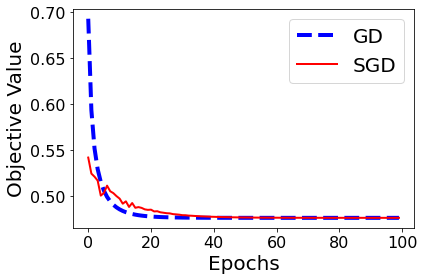

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [17]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [18]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2140625


In [19]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2265625


# 6. Mini-batch SGD (fill the code)



?]## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [39]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    
    # calculate the gradient
#     print(f"B: {b}")
#     print(f"Shape of W: {w.shape}")
#     print(f"Shape of Xi: {xi.shape}")
#     print(f"Shape of Yi: {yi.shape}")
#     Calculate yi * xi
    print("First three elements of yi")
    print(yi[:10, ...])
    print("First three rows of xi")
    print(xi[:10, ...])
    yx_mat: numpy.ndarray = numpy.multiply(yi, xi) # b-by-d matrix
    print("First three rows of yx_mat")
    print(yx_mat[:10, ...])
    yx: numpy.ndarray = numpy.sum(yx_mat, axis=0) # 1-by-d matrix
    print("a supposedly 1-by-d yx")
    print(yx)
#     print(f"Shape of yx: {yx.shape}")
    yxw: numpy.ndarray = numpy.dot(yx, w)
    print("The supposedly scalar yxw")
    print(yxw)
    den: numpy.ndarray = 1 + numpy.exp(yxw)
    print("The supposedly scalar denominator")
    print(den)
    subgradient: numpy.ndarray = (1/b) * numpy.divide(-yx, den)
    print("The supposedly 1-by-d subgradient")
    print(subgradient)
    reg: numpy.ndarray = numpy.multiply(lam, w)
    g = subgradient.reshape((d, 1)) + reg
    print("The supposedly d-by-1 gradient")
    print(g)
#     print(f"Shape of yxw: {yxw.shape}")

#     print(f"Shape of den: {den.shape}")
    
#     print(f"Shape of subgrad_matrix: {subgrad_matrix.shape}")

#     print(f"Shape of subgrad : {subgrad.shape}")

#     print(f"Shape of gradient: {g.shape}")
    
    # calculate the objective function
    
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [40]:
# Mini-Batch SGD for solving logistic regression
# Inumpyuts:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals: numpy.ndarray = numpy.zeros((max_epoch))
    if n % b != 0:
        raise ValueError("Dataset must be evenly divisible into batches. Invalid batch length")
        
    if w is None:
        w = numpy.random.randn(d, 1) # uniform random initialization
    

    
    num_batches: int = n // b
    objval = 0 # accumulate the objective values
    for e in range(max_epoch):
        rand_indices: numpy.ndarray = numpy.random.permutation(n)
        x_rand: numpy.ndarray = x[rand_indices, ...]
        y_rand: numpy.ndarray = y[rand_indices, ...]
            
        objval = 0 # accumulate objective values
        for i in range(num_batches):
            start: int = b*i
            end: int = start + b
            obj, g = mb_stochastic_objective_gradient(w, x[start:end, ...], y[start:end, ...], lam, b)
            objval += obj
            w -= stepsize*g
        
        stepsize *= 0.9 # decrease step size
        objval /= num_batches
        objvals[e] = objval
        print(f'Objective value at epoch e={str(e)} is {str(objval)}')
         
        
    
    return w, objvals

## 6.3. Run MB-SGD

In [41]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

First three elements of yi
[[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]
First three rows of xi
[[ 0.30495528 -0.01724279  0.13044183  0.14685024  0.28404983 -0.76075701
  -0.67470565 -0.3042734   1.        ]
 [-0.86198868 -0.95965887 -0.37612838 -0.16938177 -0.18055477 -0.90029469
   2.38613293 -0.7272425   1.        ]
 [ 0.30495528  2.04999246 -0.27481434  0.77931424  2.15123433 -0.12649542
   0.33659781 -0.38886722  1.        ]
 [-0.57025269  0.74277017 -3.51686372 -1.30781697 -0.69775611 -0.59584912
  -0.68966576 -0.47346104  1.        ]
 [-0.57025269 -0.95965887 -0.47744243 -1.30781697 -0.69775611 -1.1032584
  -0.83627485 -0.7272425   1.        ]
 [-0.2785167  -0.26044694 -0.98401264 -0.67535297  0.04736447 -0.34214449
   0.46525476 -0.7272425   1.        ]
 [-0.2785167   0.19556084  0.13044183  0.27334304  0.96780753  0.02572749
   0.23486906 -0.55805486  1.        ]
 [ 0.30495528  0.65156861  0.43438396 -1.30781697 -0.69775611  1.62406644
  -0.83926687  1.13382155  1.

NameError: name 'obj' is not defined

In [41]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch e=0 is [[0.95446353]]
Objective value at epoch e=1 is [[1.08502878]]
Objective value at epoch e=2 is [[1.22683486]]
Objective value at epoch e=3 is [[1.37660012]]
Objective value at epoch e=4 is [[1.53126752]]
Objective value at epoch e=5 is [[1.68799677]]
Objective value at epoch e=6 is [[1.84417124]]
Objective value at epoch e=7 is [[1.99747738]]
Objective value at epoch e=8 is [[2.14599989]]
Objective value at epoch e=9 is [[2.28826328]]
Objective value at epoch e=10 is [[2.42321026]]
Objective value at epoch e=11 is [[2.55015229]]
Objective value at epoch e=12 is [[2.66871961]]
Objective value at epoch e=13 is [[2.77880897]]
Objective value at epoch e=14 is [[2.88052508]]
Objective value at epoch e=15 is [[2.97412344]]
Objective value at epoch e=16 is [[3.05996259]]
Objective value at epoch e=17 is [[3.13846699]]
Objective value at epoch e=18 is [[3.21009854]]
Objective value at epoch e=19 is [[3.27533488]]
Objective value at epoch e=20 is [[3.33465341]]
Ob

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

In [42]:
# plot the 4 curves:

<ipython-input-43-e8438afdc3ae>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--b', LineWidth=4)
<ipython-input-43-e8438afdc3ae>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--r', LineWidth=2)


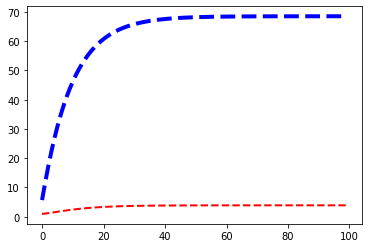

In [43]:
fig = plt.figure(figsize=(6, 4))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '--b', LineWidth=4)
line1, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--r', LineWidth=2)
plt.show()

